# Background field
Creation of a climatology using a background field create

In [1]:
using DIVAnd
using PyPlot
using NCDatasets
using PhysOcean
using DataStructures
using PyPlot
using Dates
using Statistics
using Random
using Printf

┌ Info: Precompiling PhysOcean [3725be50-bbbd-5592-92c3-2f0e82159c3e]
└ @ Base loading.jl:1260


## Files and directories
For this application we will work on the Baltic Sea.

In [ ]:
datadir = "/home/ctroupin/Projects/20190305_DivaBaltic/data/"
datafile = joinpath(datadir, "Baltic_obs.nc")
varname = "salinity"

## Inputs
### Grid and depth levels

In [30]:
Δx = 0.25
Δy = 0.25
lonr = 9.5:Δx:29.25
latr = 53.0:Δy:67.0
timerange = [Date(1900,1,1),Date(2020,12,31)];
depthr = [0.,5., 10., 15., 20., 30.];

### Data

In [21]:
@time obsval,obslon, obslat, obsdepth, obstime,obsid = DIVAnd.loadobs(Float64, datafile, varname);

 10.168579 seconds (44.46 M allocations: 4.899 GiB, 26.62% gc time)


Check the observation ranges:

In [22]:
checkobs((obslon,obslat,obsdepth,obstime),obsval,obsid)

              minimum and maximum of obs. dimension 1: (

┌ Info: Checking ranges for dimensions and observations
└ @ DIVAnd /home/ctroupin/.julia/packages/DIVAnd/rJCtr/src/obsstat.jl:75


8.972800254821777, 29.135000228881836)
              minimum and maximum of obs. dimension 2: (53.80670166015625, 65.80816650390625)
              minimum and maximum of obs. dimension 3: (0.0, 690.0)
              minimum and maximum of obs. dimension 4: (1899-12-30T00:00:00, 2013-11-07T09:16:00)
                          minimum and maximum of data: (-0.09000000357627869, 36.47800064086914)


#### Quality check based on range

In [34]:
sel = (obsval .<= 40) .& (obsval .>= 0);
obsval = obsval[sel]
obslon = obslon[sel]
obslat = obslat[sel]
obsdepth = obsdepth[sel]
obstime = obstime[sel]
obsid = obsid[sel];

#### Plot unique observation locations

In [ ]:
coords = [(x,y) for (x,y) in zip(obslon, obslat)];
coords_u = unique(coords);
@info "Total number of coordinates: $(length(coords))"
@info "Number of unique coordinates (profiles): $(length(coords_u))"
obslon_u = [x[1] for x in coords_u];
obslat_u = [x[2] for x in coords_u];

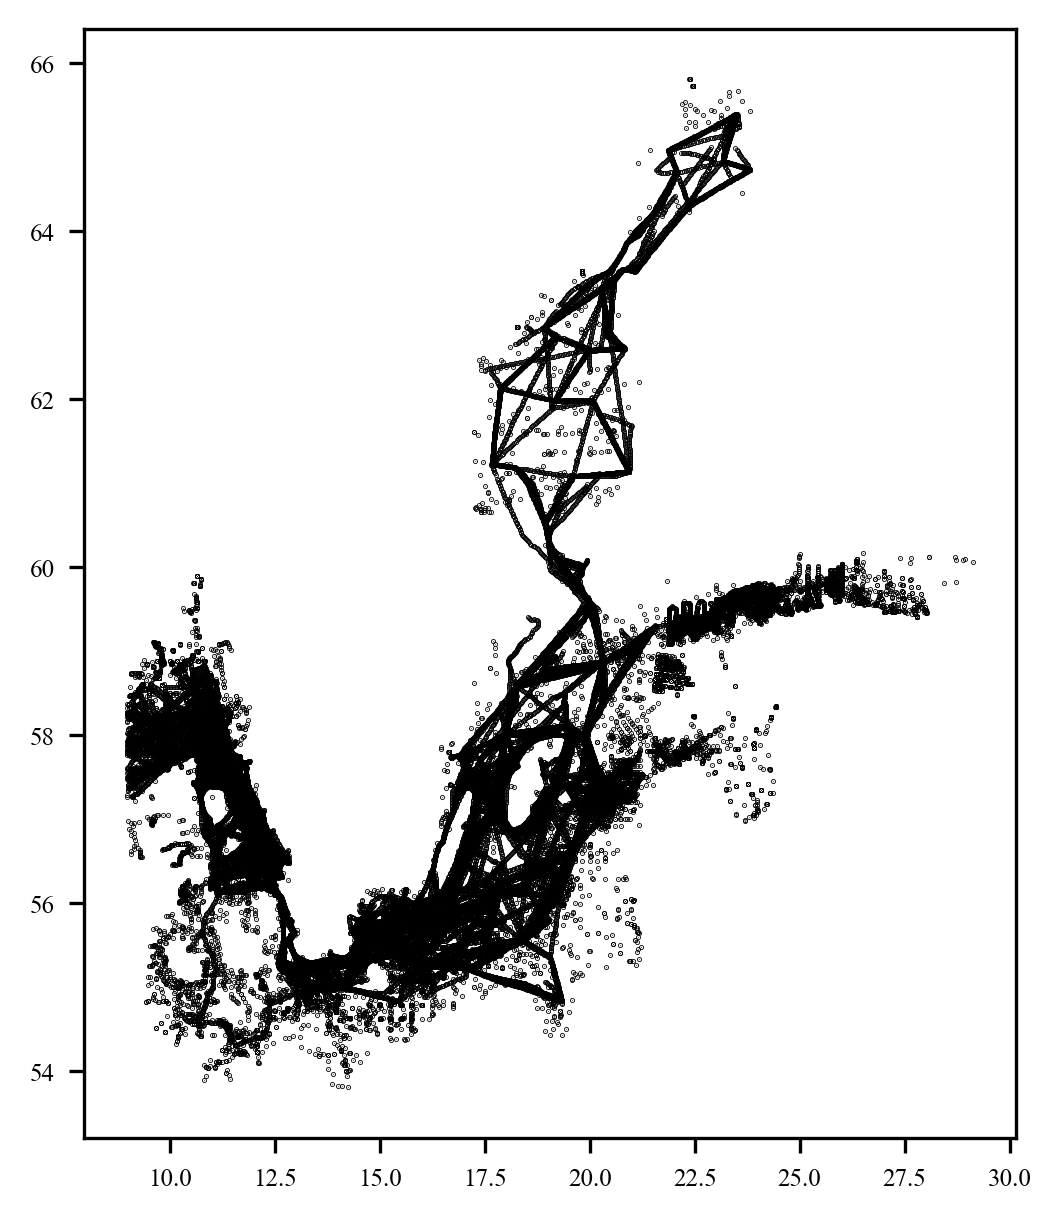

In [25]:
figure()
ax = subplot(1,1,1)
plot(obslon_u, obslat_u, "ko", markersize=.2)
aspect_ratio = 1/cos(mean(latr) * pi/180)
ax.tick_params("both",labelsize=6)
gca().set_aspect(aspect_ratio)

### Bathymetry

In [31]:
bathname = joinpath(datadir, "gebco_30sec_16.nc")
if !isfile(bathname)
    download("https://dox.ulg.ac.be/index.php/s/U0pqyXhcQrXjEUX/download", bathname)
else
    @info "Bathymetry file already downloaded"
end
@time bx, by, b = load_bath(bathname, true, lonr, latr);

  0.000956 seconds (266 allocations: 493.484 KiB)


┌ Info: Bathymetry file already downloaded
└ @ Main In[31]:5


#### Plotting

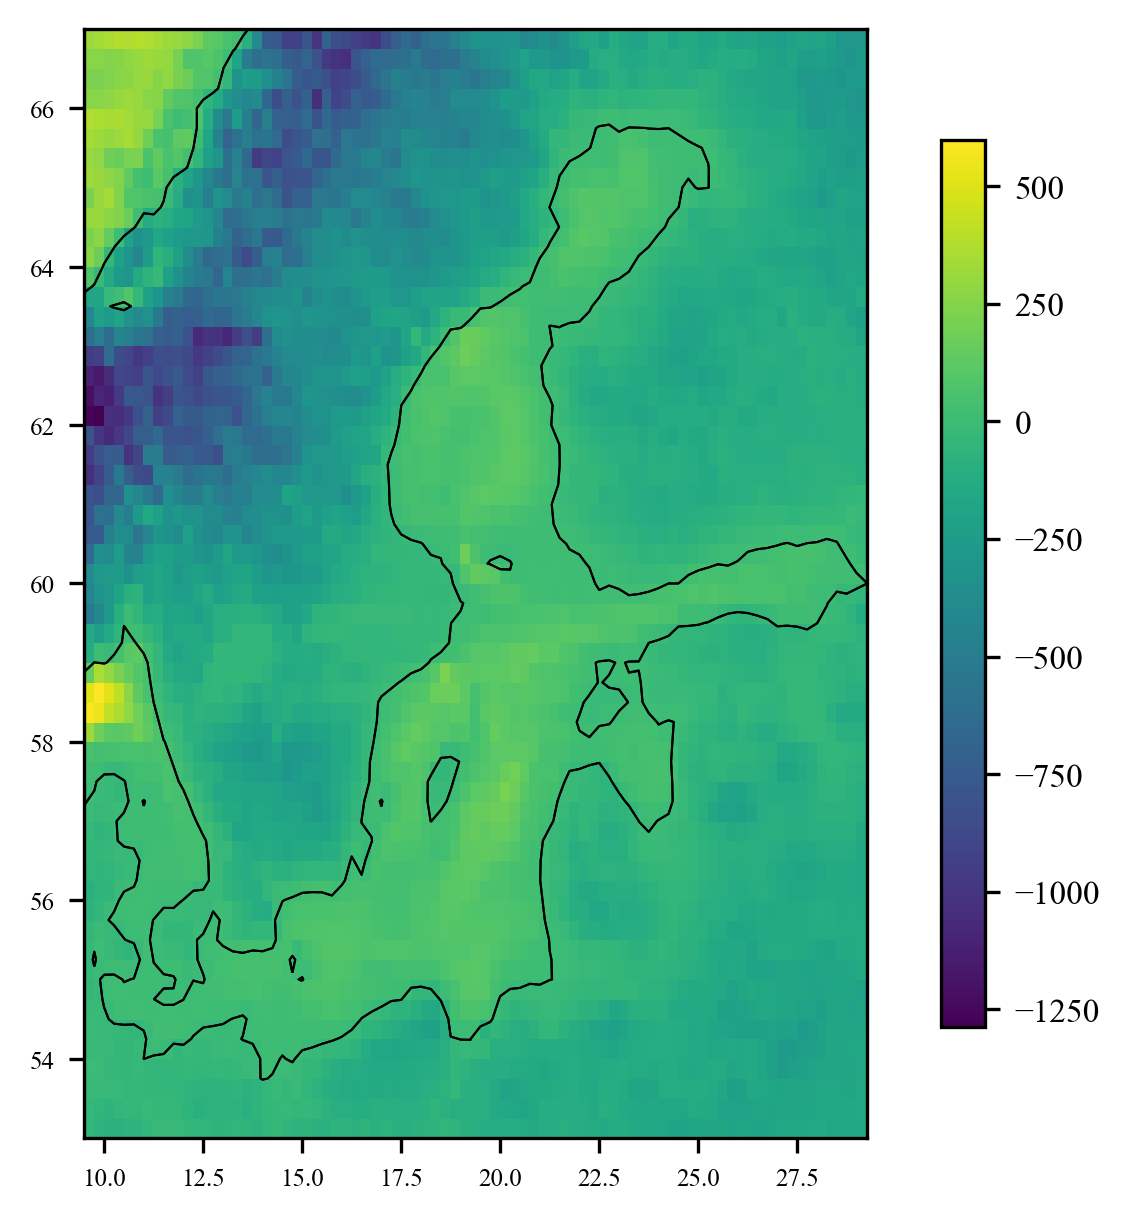

┌ Warning: `getindex(o::PyObject, s::Symbol)` is deprecated in favor of dot overloading (`getproperty`) so elements should now be accessed as e.g. `o.s` instead of `o[:s]`.
│   caller = top-level scope at In[32]:4
└ @ Core In[32]:4
┌ Warning: `getindex(o::PyObject, s::Symbol)` is deprecated in favor of dot overloading (`getproperty`) so elements should now be accessed as e.g. `o.s` instead of `o[:s]`.
│   caller = top-level scope at In[32]:4
└ @ Core In[32]:4


In [32]:
figure()
ax = subplot(1,1,1)
pcolor(bx,by,permutedims(b, [2,1]));
colorbar(orientation="vertical", shrink=0.8)[:ax][:tick_params](labelsize=8)
contour(bx,by,permutedims(b, [2,1]), [0, 0.1], colors="k", linewidths=.5)
gca().set_aspect(aspect_ratio)
ax.tick_params("both",labelsize=6)

#### Land-sea mask

In [39]:
surfwater = b .>= depthr[1]
label = DIVAnd.floodfill(surfwater)
surfmask = label .== 1; # largest area has the label 1

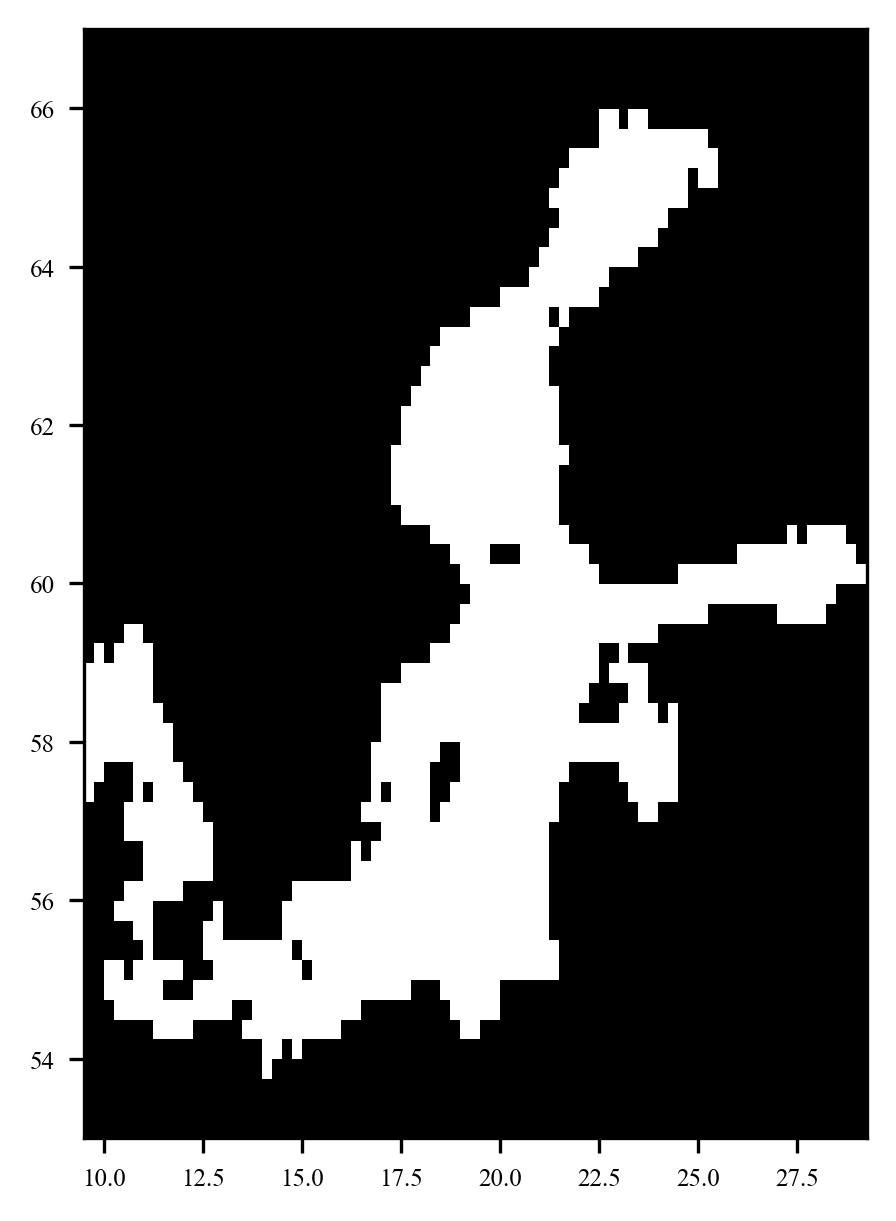

PyObject <matplotlib.collections.PolyCollection object at 0x7fb74027ed90>

In [41]:
figure()
gca().set_aspect(aspect_ratio)
gca().tick_params("both", labelsize=6)
pcolor(bx, by ,surfmask', cmap=PyPlot.cm.binary_r)

In [42]:
mask = falses(size(b,1),size(b,2),length(depthr))
for k = 1:length(depthr)
    for j = 1:size(b,2)
        for i = 1:size(b,1)
            mask[i,j,k] = (b[i,j] >= depthr[k]) && surfmask[i,j]
        end
    end
end
@show size(mask)

size(mask) = (80, 57, 6)


(80, 57, 6)

## Analysis
### Background

In [33]:
# year and month-list for background analysis
yearlist = [1900:1989,1990:2017];
monthlist = [[1,2,3],[4,5,6],[7,8,9],[10,11,12]];  # Seasonal climatology
TSbackground = DIVAnd.TimeSelectorYearListMonthList(yearlist,monthlist);

#### Analysis parameters

In [43]:
sz = (length(lonr), length(latr), length(depthr));
lenx = fill(200_000.,sz)   # 200 km
leny = fill(200_000.,sz)   # 200 km
lenz = [min(max(30.,depthr[k]/150),300.) for i = 1:sz[1], j = 1:sz[2], k = 1:sz[3]]
len = (lenx, leny, lenz);
epsilon2 = 0.1;

filenamebackground = "Water_body_$(replace(varname," "=>"_"))_Atlantic_background.4Danl.nc"
filename = "Water_body_$(replace(varname," "=>"_"))_Atlantic.4Danl.nc"

"Water_body_salinity_Atlantic.4Danl.nc"

#### Metadata for the netCDF file

In [44]:
metadata = OrderedDict(
    # Name of the project (SeaDataCloud, SeaDataNet, EMODNET-chemistry, ...)
    "project" => "SeaDataCloud",

    # URN code for the institution EDMO registry,
    # e.g. SDN:EDMO::1579
    "institution_urn" => "SDN:EDMO::1579",

    # Production group
    #"production" => "Diva group",

    # Name and emails from authors
    "Author_e-mail" => ["Your Name1 <name1@example.com>", "Other Name <name2@example.com>"],

    # Source of the observation
    "source" => "observational data from SeaDataNet and World Ocean Atlas",

    # Additional comment
    "comment" => "Duplicate removal applied to the merged dataset",

    # SeaDataNet Vocabulary P35 URN
    # http://seadatanet.maris2.nl/v_bodc_vocab_v2/search.asp?lib=p35
    # example: SDN:P35::WATERTEMP
    "parameter_keyword_urn" => "SDN:P35::EPC00001",

    # List of SeaDataNet Parameter Discovery Vocabulary P02 URNs
    # http://seadatanet.maris2.nl/v_bodc_vocab_v2/search.asp?lib=p02
    # example: ["SDN:P02::TEMP"]
    "search_keywords_urn" => ["SDN:P02::PSAL"],

    # List of SeaDataNet Vocabulary C19 area URNs
    # SeaVoX salt and fresh water body gazetteer (C19)
    # http://seadatanet.maris2.nl/v_bodc_vocab_v2/search.asp?lib=C19
    # example: ["SDN:C19::3_1"]
    "area_keywords_urn" => ["SDN:C19::3_3"],

    "product_version" => "1.0",

    "product_code" => "something-to-decide",

    # bathymetry source acknowledgement
    # see, e.g.
    # * EMODnet Bathymetry Consortium (2016): EMODnet Digital Bathymetry (DTM).
    # http://doi.org/10.12770/c7b53704-999d-4721-b1a3-04ec60c87238
    #
    # taken from
    # http://www.emodnet-bathymetry.eu/data-products/acknowledgement-in-publications
    #
    # * The GEBCO Digital Atlas published by the British Oceanographic Data Centre on behalf of IOC and IHO, 2003
    #
    # taken from
    # https://www.bodc.ac.uk/projects/data_management/international/gebco/gebco_digital_atlas/copyright_and_attribution/

    "bathymetry_source" => "The GEBCO Digital Atlas published by the British Oceanographic Data Centre on behalf of IOC and IHO, 2003",

    # NetCDF CF standard name
    # http://cfconventions.org/Data/cf-standard-names/current/build/cf-standard-name-table.html
    # example "standard_name" = "sea_water_temperature",
    "netcdf_standard_name" => "sea_water_salinity",

    "netcdf_long_name" => "sea water salinity",

    "netcdf_units" => "1e-3",

    # Abstract for the product
    "abstract" => "...",

    # This option provides a place to acknowledge various types of support for the
    # project that produced the data
    "acknowledgement" => "...",

    "documentation" => "http://dx.doi.org/doi_of_doc",

    # Digital Object Identifier of the data product
    "doi" => "...");

ncglobalattrib, ncvarattrib = SDNMetadata(metadata, filename, varname, lonr, latr);

In [ ]:
if isfile(filenamebackground)
    rm(filenamebackground) # delete the previous analysis
    @info "Removing file $filenamebackground"
end

figdir = "./Atlantic/figures/"
if ~(isdir(figdir))
    mkpath(figdir);
    @info "Creating directory $(figdir)"
end
solver = :direct

function plotres(timeindex,sel,fit,erri)
    tmp = copy(fit)
    nx,ny,nz = size(tmp)
    for i in 1:nz
        figure("Atlantic analysis")
        ax = subplot(1,1,1)
        ax[:tick_params]("both",labelsize=6)
        ylim(minimum(latr) - Δy, maximum(latr) + Δy);
        xlim(minimum(lonr) - Δx, maximum(lonr) + Δx);
        title("Depth: $(depthr[i]) \n Time index: $(timeindex)", fontsize=6)
        pcolor(lonr.-Δx/2.,latr.-Δy/2, permutedims(tmp[:,:,i], [2,1]);
               vmin = 33, vmax = 40)
        colorbar(extend="both", orientation="vertical", shrink=0.8)[:ax][:tick_params](labelsize=8)

        contourf(bx,by,permutedims(b,[2,1]), levels = [-1e5,0],colors = [[.5,.5,.5]])
        gca()[:set_aspect](aspect_ratio)

        figname = varname * @sprintf("_%02d",i) * @sprintf("_%03d.png",timeindex)
        PyPlot.savefig(joinpath(figdir, figname), dpi=300, bbox_inches="tight");
        PyPlot.close_figs()
    end
end

# background analysis
dbinfo = @time diva3d((lonr,latr,depthr,TSbackground),
           (obslon,obslat,obsdepth,obstime), obsval,
           len, epsilon2,
           filenamebackground,varname,
           bathname=bathname,
           mask = mask,
           fitcorrlen = false,
           niter_e = 2,
           ncvarattrib = ncvarattrib,
           ncglobalattrib = ncglobalattrib,
           solver = solver,
           MEMTOFIT = 120,
       );


yearlist = [1970:1979,1980:1989,1990:1999,2000:2009];
monthlist = [[1,2,3],[4,5,6],[7,8,9],[10,11,12]];  # Seasonal climatology
TS = DIVAnd.TimeSelectorYearListMonthList(yearlist,monthlist);

if isfile(filename)
    rm(filename) # delete the previous analysis
    @info "Removing file $filenamebackground"
end

# analysis using background field

dbinfo = @time diva3d((lonr,latr,depthr,TS),
    (obslon,obslat,obsdepth,obstime), obsval,
    len, epsilon2,
    filename,varname,
    bathname=bathname,
#    plotres = plotres,
    mask = mask,
    fitcorrlen = false,
    niter_e = 2,
    ncvarattrib = ncvarattrib,
    ncglobalattrib = ncglobalattrib,
    background = DIVAnd.backgroundfile(filenamebackground,varname,TSbackground),
    solver = solver,
    MEMTOFIT = 120,
);


@show length(obslat);